# Compare with the LSP product on TERN

From here: https://portal.tern.org.au/metadata/TERN/2bb0c81a-41a9-434c-b87a-db0301cb52fb

paper: https://www.sciencedirect.com/science/article/pii/S1364815214003430?casa_token=8yGCjrtpoUEAAAAA:rgFiQIST1MBsUwZh0yaQ0vLFuzTHZI72qYs51NeEbG2EqjIDEkDJCHQDlYHX81sVBNvP4940NtU

## Load packages

In [1]:
import sys
import os
import pickle
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
from rioxarray import merge
from odc.geo.xr import assign_crs
import matplotlib as mpl
from odc.geo.xr import write_cog
from odc.geo.geom import Geometry
import contextily as ctx
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.simplefilter(action='ignore')

## Process the TERN EVI Phenology data into a time series

Only needed to do this once

In [2]:
# var='TOS'

In [3]:
# base='/g/data/os22/chad_tmp/Aus_phenology/data/tern/'+var+'/'
# files = [base+i for i in os.listdir(base) if i.endswith('Season1.tif')]
# files.sort()

In [4]:
# tifs = []
# for f in files:
#     time = f[-16:-12]
#     time = datetime.strptime(time, "%Y")
#     # time = np.datetime64(time)
#     da = rxr.open_rasterio(f).squeeze().drop_vars('band')
#     da = da.expand_dims(time=[time])
#     tifs.append(da)

# ds = xr.concat(tifs, dim='time').sortby('time')

# #reproject
# ds = assign_crs(ds, crs='epsg:4326')
# path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
# gbox = xr.open_dataset(path).odc.geobox
# ds = ds.odc.reproject(how=gbox, resampling='average')
# #remove nodata
# ds = ds.where(ds>0)
# #export
# ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/tern/'+var+'_2003_2018.nc')

## Open ecoregions


In [5]:
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
gdf = gpd.read_file(ecoregions_file)

## Open AusENDVI phenology

And calculate means phenometrics over the same interval as TERN (2003-2018)

In [6]:
phenometrics_file = '/g/data/os22/chad_tmp/Aus_phenology/data/IBRA_subregions_phenometrics.pkl'
with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

In [7]:
var='SUB_NAME_7'
means = []
for k in phenometrics.keys():
    df = phenometrics[k]
    #clip to same range as TERN
    df = df[(df['POS_year']>=2003.0) & (df['POS_year']<=2018.0)]
    #include a column counting the number of seasons
    df['n_seasons'] = len(df)
    # df = df.drop_duplicates(subset=['POS_year'], keep='first')
    mean_df = df.quantile(q=0.5, interpolation='lower') # median
    mean_df = mean_df.rename({i:'This Study '+i for i in mean_df.index}).to_frame().transpose()
    mean_df[var] = k

    mean_gdf = gdf.merge(mean_df, on=var)
    means.append(mean_gdf)
    
pheno_means = pd.concat(means).reset_index(drop=True)
pheno_means = pheno_means[['SUB_NAME_7','This Study SOS', 'This Study POS', 'This Study EOS', 'geometry']] #subset

## Calculate mean phenology over polygons for TERN

In [8]:
sgs = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/tern/SGS_2003_2018.nc').median('time')
pgs = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/tern/PGS_2003_2018.nc').median('time')
egs = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/tern/EGS_2003_2018.nc').median('time')

In [9]:
sgs_tern={}
pgs_tern={}
egs_tern={}
i=0
for index, row in gdf.iterrows():
    print("Feature {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")
    
    #clip to ecoregion
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    sgs_clip = sgs.odc.mask(poly=geom)
    sgs_clip = sgs_clip.median(['latitude', 'longitude'])

    pgs_clip = pgs.odc.mask(poly=geom)
    pgs_clip = pgs_clip.median(['latitude', 'longitude'])

    egs_clip = egs.odc.mask(poly=geom)
    egs_clip = egs_clip.median(['latitude', 'longitude'])
    if np.isnan(sgs_clip):
        continue
    else:
        sgs_tern[row[var]] = sgs_clip.values.item()
        pgs_tern[row[var]] = pgs_clip.values.item()
        egs_tern[row[var]] = egs_clip.values.item()
        i+=1
        
sgs_df = pd.DataFrame(sgs_tern, index=['Tern SOS']).transpose().reset_index().rename({'index':'SUB_NAME_7'},axis=1)
pgs_df = pd.DataFrame(pgs_tern, index=['Tern POS']).transpose().reset_index().rename({'index':'SUB_NAME_7'},axis=1)
egs_df = pd.DataFrame(egs_tern, index=['Tern EOS']).transpose().reset_index().rename({'index':'SUB_NAME_7'},axis=1)

#join everything
gdf = gdf.merge(sgs_df, on='SUB_NAME_7')
gdf = gdf.merge(pgs_df, on='SUB_NAME_7')
gdf = gdf.merge(egs_df, on='SUB_NAME_7')
gdf = gdf.merge(pheno_means.drop('geometry',axis=1), on='SUB_NAME_7')

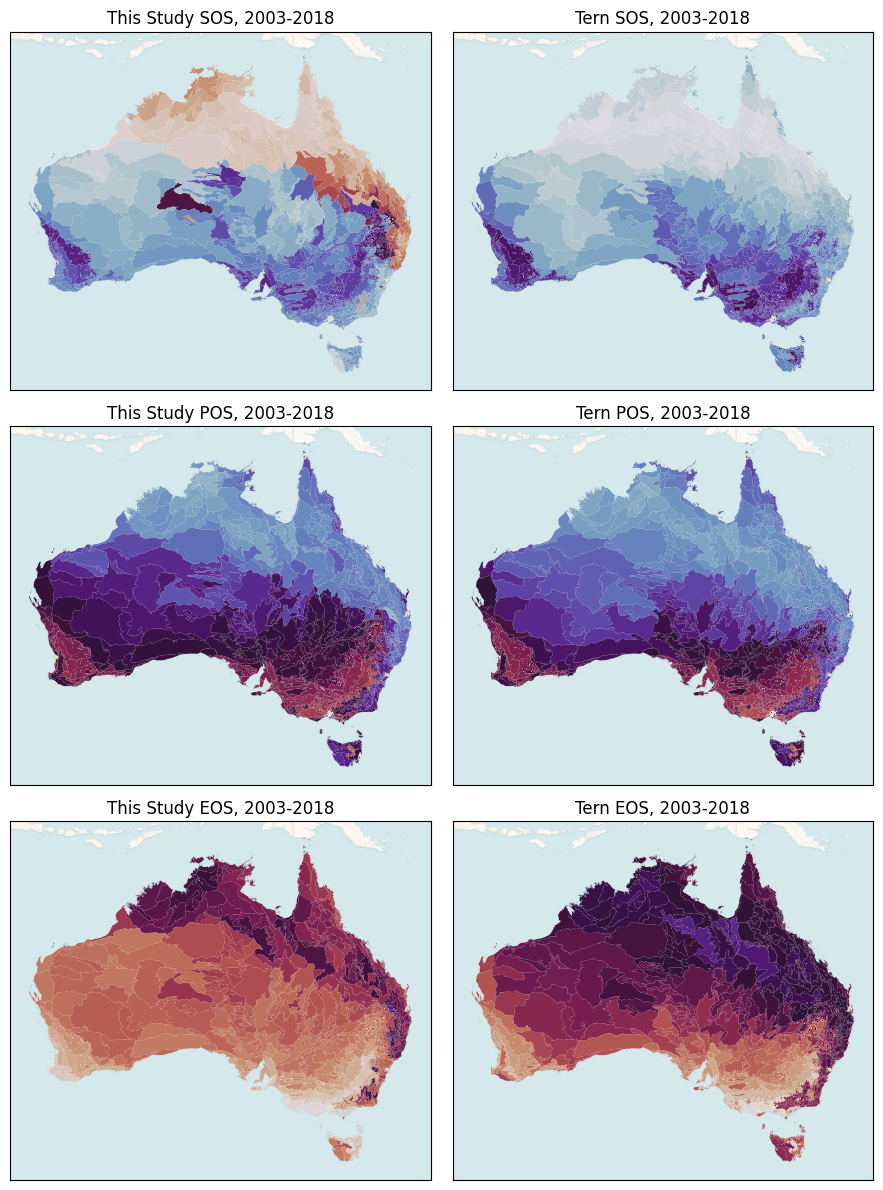

In [10]:
fig,axes=plt.subplots(3,2, figsize=(9,12), sharey=True, sharex=True)
pheno_stats=['This Study SOS','Tern SOS',
             'This Study POS', 'Tern POS',
             'This Study EOS', 'Tern EOS'
      ]
cmaps = ['twilight', 'twilight',
         'twilight', 'twilight',
         'twilight', 'twilight'
        ]

for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):

    vmin, vmax=0, 365
    label='DOY'
    im=gdf.plot(column=pheno, ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)
    ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(f'{pheno}, 2003-2018')

plt.tight_layout()
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/Compare_with_TERN_phenology.png',
            bbox_inches='tight', dpi=300)

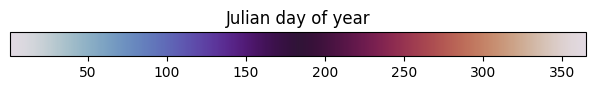

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.05])
# cbar = fig.colorbar(im, )
cbar = mpl.colorbar.ColorbarBase(orientation='horizontal',
                                 ax=ax,
                                 norm = mpl.colors.Normalize(vmin=1, vmax=365),
                                 ticks=list(range(0,365, 50)),
                                 cmap='twilight')
cbar.ax.set_title('Julian day of year', fontsize=12)
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/dayofyear_legend.png',
            bbox_inches='tight', dpi=300)

In [12]:
# ds.odc.explore(
#            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )